# 2.3　連続確率分布

　この章では，連続値を生成する確率分布（ベータ分布，ディリクレ分布，ガンマ分布，１次元ガウス分布，多次元ガウス分布）を紹介します．ここで紹介する確率分布は，ベイズ学習においてほかの確率分布に対する共役事前分布として扱われることが多く，計算効率の高い学習アルゴリズムを実現するための必須パーツになっています．

## 2.3.1　ベータ分布

　**ベータ分布（beta distibution）**は$\ \mu \in (0,1)\ $となるような変数を生成する確率分布です．

$$ \mathrm{Beta}(\mu \mid a,b) = C_{\mathrm{B}}(a,b) \mu^{a-1} (1-\mu)^{b-1}$$

ここで，$\ a \in \mathbb{R}^+\ $および$\ b \in \mathbb{R}^+\ $はこの分布のパラメータです．また，$\ C_{\mathrm{B}}(a,b)\ $はこの確率分布が正規化されることを保証するための項で，具体的には**ガンマ関数（gamma function）**を用いて次のように計算できます．

$$ C_{\mathrm{B}}(a,b) = \frac{\Gamma(a,b)}{\Gamma(a)\Gamma(b)}$$

In [1]:
#可視化メソッドの定義
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
%matplotlib inline
plt.style.use("seaborn-whitegrid")

def visual_beta(a, b):
    x = np.linspace(0, 1, 1000)
    y = beta.pdf(x, a, b)
    plt.plot(x, y, label = "$a=$" + str(a) + ", " + "$b=$" + str(b))
    plt.xlim(0, 1)
    plt.ylim(0, 8)
    plt.xlabel("$\mu$")
    plt.ylabel("probability density")
    plt.legend()

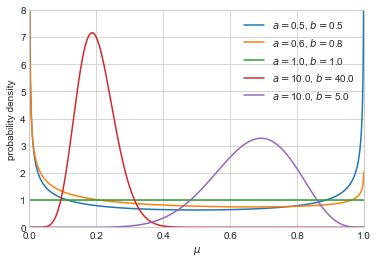

In [2]:
#実行
visual_beta(0.5, 0.5)
visual_beta(0.6, 0.8)
visual_beta(1.0, 1.0)
visual_beta(10.0, 40.0)
visual_beta(10.0, 5.0)

## 2.3.2　ディリクレ分布

　**ディリクレ分布（Dirichlet distribution）**はベータ分布を多次元に拡張したものになります．すなわち，$\ K\ $次元ベクトルを$\ \boldsymbol{\pi} = (\pi_1,...,\pi_K)\ $としたとき，$\ \sum_{k=1}^{K} \pi_k = 1\ $かつ$\ \pi \in (0,1)\ $が満たされるような$\ \boldsymbol{\pi}\ $を生成する確率分布です．

$$\ \mathrm{Dir}(\boldsymbol{\pi} \mid \boldsymbol{\alpha}) = C_{\mathrm{D}}(\boldsymbol{\alpha}) \prod_{k=1}^{K} {\pi_k}^{\alpha_k - 1}\ $$

ここで$\ K\ $次元のパラメータ$\ \boldsymbol{\alpha}\ $のそれぞれの要素$\ \alpha_k\ $は正の実数であり，正規化項$\ C_{\mathrm{D}}(\boldsymbol{\alpha})\ $は次のように計算されます．

$$ C_{\mathrm{D}}(\boldsymbol{\alpha}) =\frac{\Gamma(\sum_{k=1}^{K} \alpha_k)}{\prod_{k=1}^{K} \Gamma(\alpha_k)}$$

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from mpl_toolkits.mplot3d import Axes3D

def dirichlet_pdf(pi, alpha):
    if np.any(pi < 0) or np.any(pi > 1) or pi.sum()<0 or pi.sum()>1:
        return 0
    else:
        out = (gamma(np.sum(alpha) / np.prod(gamma(alpha))))
        for i in range(len(pi)):
            out *= pi[i] ** (alpha[i] - 1)    
        return out

def visual_dirichlet(alpha):
    x = y = np.linspace(0, 1, 0.01)
    x, y = np.meshgrid(x, y)
    x, y = x.ravel(), y.ravel()
    
    z = []
    for i in range(len(x)):
        z.append([x[i], y[i], 1-x[i]-y[i]])
    Z = []
    for k in z:
        Z.append(dirichlet_pdf(k, alpha))
        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, Z)
    #ax.set_title("M =" + str(M) + ", " + "$\pi =$" + str(pi), fontsize=10)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    #ax.set_zlim3d(bottom=0, top=0.2)
    #ax.set_zticks(np.arange(0, 0.21, 0.05))
    plt.show()

/Users/takakimichihito/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


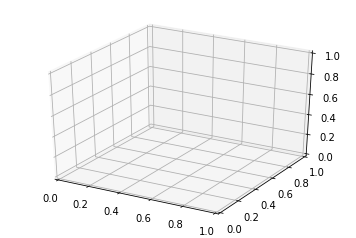

In [13]:
visual_dirichlet([0.5, 0.5, 0.5])

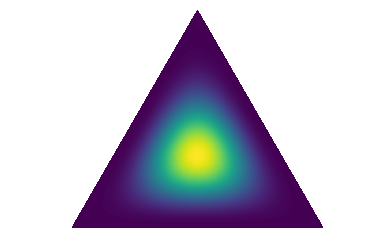

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import functools

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

# Mid-points of triangle sides opposite of each corner
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     functools.reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * functools.reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])

def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

draw_pdf_contours(Dirichlet([4, 4, 4]))

## 2.3.3　ガンマ分布

　**ガンマ分布（gamma distribution）**は正の実数$\ \lambda \in \mathbb{R}^+\ $を生成する確率分布であり，次のように定義されます．

$$ \mathrm{Gam}(\lambda \mid a,b) = C_{\mathrm{G}}(a,b) \lambda^{a-1} e^{-b\lambda}$$

ここで，パラメータ$\ a\ $および$\ b\ $はともに正の実数であり，正規化項$\ C_{\mathrm{G}}(a,b)\ $は次のように計算されます．

$$ C_{\mathrm{G}}(a,b) = \frac{b^a}{\Gamma(a)} $$

In [3]:
#可視化メソッドの定義
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
%matplotlib inline

def visual_gamma(a, b):
    def gamma_distribution(la, a, b):
        return b**a / gamma(a) * la**(a-1) * np.e**(-b*la)
    x = np.linspace(0, 10, 1000)
    y = gamma_distribution(x, a, b)
    plt.plot(x, y, label = "$a=$" + str(a) + ", " + "$b=$" + str(b))
    plt.xlim(0, 10)
    plt.ylim(0, 1.4)
    plt.xlabel("$\lambda$")
    plt.ylabel("probability density")
    plt.legend()

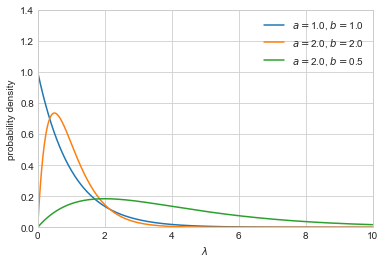

In [4]:
#実行
visual_gamma(1.0, 1.0)
visual_gamma(2.0, 2.0)
visual_gamma(2.0, 0.5)

## 2.3.4　１次元ガウス分布

　**ガウス分布（Gaussian distribution）**または**正規分布（normal distribution）**は，統計学はもちろん，機械学習の分野においてももっとも重要な役割をもつ確率分布です．$\ x \in \mathbb{R}\ $を生成する１次元ガウス分布の確率密度関数は次のように定義されます．

$$ \mathcal{N}(x \mid \mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left\{ -\frac{(x-\mu)^2}{2\sigma^2} \right\} $$

ここで，$\ \mu \in \mathbb{R}\ $は平均パラメータであり，ガウス分布の中心位置を指し示しています．さらに，$\ \sigma^2 \in \mathbb{R}^+\ $は分散パラメータであり，ガウス分布の広がり具合を示しています．それでは，いくつかの異なる$\ \mu\ $および$\ \sigma\ $に対するガウス分布を確認してみましょう．

In [5]:
#可視化メソッドの定義
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

def visual_normal(mu, sigma):
    x = np.linspace(-10, 10, 1000)
    y = norm.pdf(x, mu, sigma)
    plt.plot(x, y, label = "$\mu=$" + str(mu) + ", " + "$\sigma=$" + str(sigma))
    plt.xlim(-10, 10)
    plt.ylim(0, 1.4)
    plt.xlabel("$x$")
    plt.ylabel("probability density")
    plt.legend()

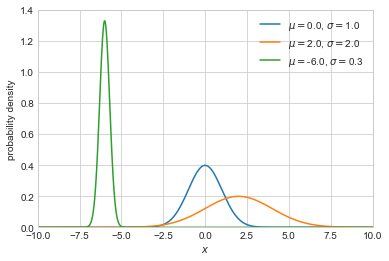

In [6]:
#実行
visual_normal(0.0, 1.0)
visual_normal(2.0, 2.0)
visual_normal(-6.0, 0.3)

## 2.3.5　多次元ガウス分布

　１次元ガウス分布をより一般的な$\ D\ $次元に拡張したものを**多次元ガウス分布（multivariate Gaussian distribution）**と呼びます．これはベクトル$\ \mathrm{\mathbf{x}} \in \mathbb{R}^D\ $を生成するための確率分布であり，次のように定義されます．

$$ \mathcal{N}(\mathrm{\mathbf{x}} \mid \boldsymbol{\mu},\boldsymbol{\Sigma}) = \frac{1}{\sqrt{(2\pi)^D |\boldsymbol{\Sigma}|}} \exp \left\{ -\frac{1}{2} (\mathrm{\mathbf{x}-\boldsymbol{\mu}})^{\mathrm{T}} \boldsymbol{\Sigma}^{-1} (\mathrm{\mathbf{x}-\boldsymbol{\mu}}) \right\} $$

ここで，$\ \boldsymbol{\mu} \in \mathbb{R}^D \ $は平均パラメータであり，**共分散行列（covariance matrix）**パラメータ$\ \boldsymbol{\Sigma}\ $はサイズが$\ D \times D\ $であるような**正定値対称行列**である必要があります．また，$\ |\boldsymbol{\Sigma}|\ $は$\ \boldsymbol{\Sigma}\ $の**行列式**です．それでは，２次元ガウス分布のグラフを座標空間上に描画してみましょう．

In [14]:
#可視化メソッドの定義
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

def visual_gauss2d(Mu, Sigma):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-4.0, 4.0, 0.01)
    X, Y = np.meshgrid(x, y) 
    
    #平均と分散
    mu = np.array(Mu)
    sigma = np.array(Sigma)
    
    #行列式
    det = np.linalg.det(sigma)
    
    #逆行列
    inv_sigma = np.linalg.inv(sigma)
    
    #ガウス二次元確率密度を返す関数
    def f(x, y):
        x_c = np.array([x, y]) - mu
        return np.exp(- x_c.dot(inv_sigma).dot(x_c[np.newaxis, :].T) / 2.0) / (2*np.pi*np.sqrt(det))
    
    #配列それぞれ対応するものを返す関数に変える
    Z = np.vectorize(f)(X,Y)
    
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.Greys)
    plt.show()
    
    #等高線
    x, y = np.mgrid[-10:10:0.1, -10:10:0.1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal(Mu, Sigma)
    plt.xlim(-4.0, 4.0)
    plt.ylim(-4.0, 4.0)
    plt.contourf(x, y, rv.pdf(pos), cmap=cm.Greys)
    plt.colorbar()
    plt.show()

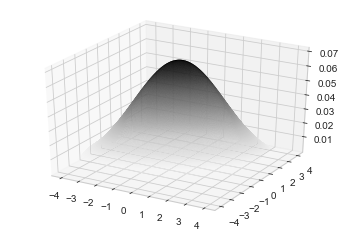

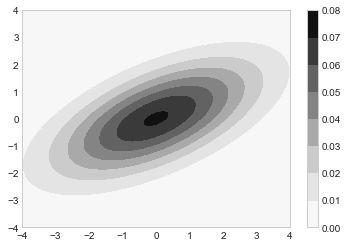

In [15]:
#実行
visual_gauss2d([0,0], [[4.0, np.sqrt(3)], [np.sqrt(3), 2.0]])